In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam

import sys
sys.path.append('../module/')

import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.0005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [5]:
#safe learning
l = 0.
step = 40000
time_mode = True
a = agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=5000, loss_graph=0, time_mode=time_mode)







Training for 40000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -2.6401
2 episodes - episode_reward: -13200.458 [-13609.668, -12791.249] - loss: 5.168 - mean_absolute_error: 0.225 - mean_q: -2.726

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -2.3968
2 episodes - episode_reward: -11984.167 [-12727.941, -11240.393] - loss: 5.842 - mean_absolute_error: 0.313 - mean_q: -7.831

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 70s 7ms/step - reward: -4.3349
2 episodes - episode_reward: -21674.624 [-25557.272, -17791.976] - loss: 7.704 - mean_absolute_error: 0.397 - mean_q: -17.316

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -4.4651
done, took 257.685 seconds


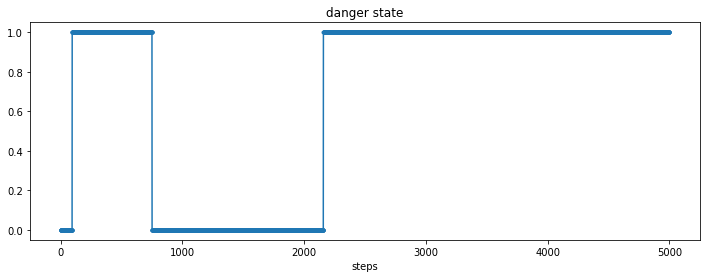

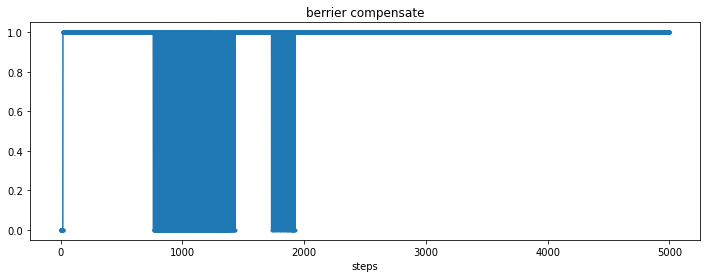

In [10]:
plt.figure(figsize=(12,4))
plt.title('danger state')
plt.xlabel('steps')
plt.plot(range(5000), a.cbf_log[:5000,0], marker='.')
plt.show()
plt.figure(figsize=(12,4))
plt.xlabel('steps')
plt.title('berrier compensate')
plt.plot(range(5000), a.cbf_log[:5000,1], marker='.')
plt.show()

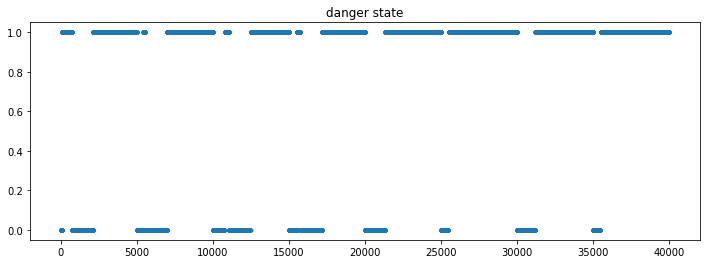

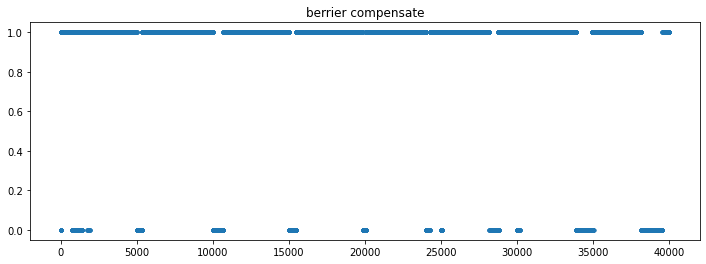

In [6]:
plt.figure(figsize=(12,4))
plt.title('danger state')
plt.scatter(range(step), a.cbf_log[:,0], marker='.')
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.scatter(range(step), a.cbf_log[:,1], marker='.')
plt.show()

In [10]:
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.test(env, lam=l, visualize=0, nb_max_episode_steps=2000, action_view=0, time_mode=time_mode)

Testing for 1 episodes ...
Episode 1: reward: -122.440, steps: 2000


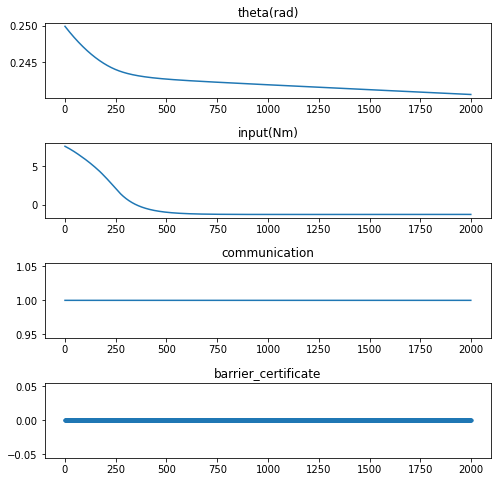

In [11]:
titles = ['theta(rad)', 'input(Nm)', 'communication', 'barrier_certificate'] 
history = a.data_log[0]
x_axis = range(2000)
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(4):
    data = history[:,i]
    plt.subplot(4,1,i+1)
    plt.title(titles[i])
    if i < 3:
        plt.plot(x_axis, data)
    else:
        plt.scatter(x_axis, data, marker='.')
plt.show()

In [9]:
print(np.unique(history[:,1]))

[-2.          0.44251469  2.        ]


(array([ 949.,   11.,    0.,    0.,    4.,   12.,    5.,    3.,    3.,
        1013.]),
 array([-3.14158925e+00, -2.51327466e+00, -1.88496007e+00, -1.25664549e+00,
        -6.28330898e-01, -1.63091561e-05,  6.28298279e-01,  1.25661287e+00,
         1.88492746e+00,  2.51324205e+00,  3.14155663e+00]),
 <a list of 10 Patch objects>)

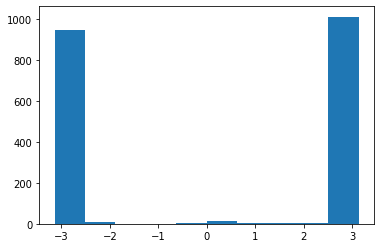

In [11]:
plt.hist(history[:,0])

In [29]:
theta = np.pi / 4
for i in range(1, 5):
    theta = (2*i - 5) * np.pi / 4
    o = np.array([np.cos(theta), np.sin(theta), 1])
    print(_obs_to_rad(o), f'{(2*i - 5)}π/ 4 = {theta}')

-2.356194490192345 -3π/ 4 = -2.356194490192345
-0.7853981633974483 -1π/ 4 = -0.7853981633974483
0.7853981633974483 1π/ 4 = 0.7853981633974483
2.356194490192345 3π/ 4 = 2.356194490192345
